In [1]:
# Uninstall existing transformers to avoid conflicts
!pip uninstall -y transformers
# Install transformers and decord
!pip install transformers==4.44.2 decord

Found existing installation: transformers 4.57.1
Uninstalling transformers-4.57.1:
  Successfully uninstalled transformers-4.57.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 120.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 124.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 111.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1


In [2]:
!git clone https://github.com/facebookresearch/vjepa2
import sys
sys.path.append('/kaggle/working/vjepa2')

Cloning into 'vjepa2'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 310 (delta 45), reused 33 (delta 33), pack-reused 239 (from 3)
Receiving objects: 100% (310/310), 576.64 KiB | 14.06 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [3]:
import os

# Download sample video
sample_video_path = "sample_video.mp4"
if not os.path.exists(sample_video_path):
    !wget https://huggingface.co/datasets/nateraw/kinetics-mini/resolve/main/val/bowling/-WH-lxmGJVY_000005_000015.mp4 -O sample_video.mp4
    print("Downloaded sample video")

# Download SSV2 classes
ssv2_classes_path = "ssv2_classes.json"
if not os.path.exists(ssv2_classes_path):
    !wget https://huggingface.co/datasets/huggingface/label-files/resolve/d79675f2d50a7b1ecf98923d42c30526a51818e2/something-something-v2-id2label.json -O ssv2_classes.json
    print("Downloaded SSV2 classes")

# Download PyTorch model weights
pt_model_path = "vitg-384.pt"
if not os.path.exists(pt_model_path):
    !wget https://dl.fbaipublicfiles.com/vjepa2/vitg-384.pt -O vitg-384.pt
    print("Downloaded V-JEPA encoder weights")

classifier_model_path = "ssv2-vitg-384-64x2x3.pt"
if not os.path.exists(classifier_model_path):
    !wget https://dl.fbaipublicfiles.com/vjepa2/evals/ssv2-vitg-384-64x2x3.pt -O ssv2-vitg-384-64x2x3.pt
    print("Downloaded classifier weights")

--2025-12-23 11:35:44--  https://huggingface.co/datasets/nateraw/kinetics-mini/resolve/main/val/bowling/-WH-lxmGJVY_000005_000015.mp4
Resolving huggingface.co (huggingface.co)... 18.239.50.103, 18.239.50.16, 18.239.50.80, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.103|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: /api/resolve-cache/datasets/nateraw/kinetics-mini/9f4ed38128a355c352527209101be3e326471816/val%2Fbowling%2F-WH-lxmGJVY_000005_000015.mp4?%2Fdatasets%2Fnateraw%2Fkinetics-mini%2Fresolve%2Fmain%2Fval%2Fbowling%2F-WH-lxmGJVY_000005_000015.mp4=&etag=%2264aa6e6754331c7e567b1b4beaeb48f27cb4bd4f%22 [following]
--2025-12-23 11:35:44--  https://huggingface.co/api/resolve-cache/datasets/nateraw/kinetics-mini/9f4ed38128a355c352527209101be3e326471816/val%2Fbowling%2F-WH-lxmGJVY_000005_000015.mp4?%2Fdatasets%2Fnateraw%2Fkinetics-mini%2Fresolve%2Fmain%2Fval%2Fbowling%2F-WH-lxmGJVY_000005_000015.mp4=&etag=%2264aa6e6754331c7e567b1

In [4]:
import json
import os
import numpy as np
import torch
import torch.nn.functional as F
from decord import VideoReader

# Import custom modules from the cloned repository
import src.datasets.utils.video.transforms as video_transforms
import src.datasets.utils.video.volume_transforms as volume_transforms
from src.models.attentive_pooler import AttentiveClassifier
from src.models.vision_transformer import vit_giant_xformers_rope

IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

def load_pretrained_vjepa_pt_weights(model, pretrained_weights):
    pretrained_dict = torch.load(pretrained_weights, weights_only=True, map_location="cpu")["encoder"]
    pretrained_dict = {k.replace("module.", ""): v for k, v in pretrained_dict.items()}
    pretrained_dict = {k.replace("backbone.", ""): v for k, v in pretrained_dict.items()}
    msg = model.load_state_dict(pretrained_dict, strict=False)
    print("Pretrained weights found at {} and loaded with msg: {}".format(pretrained_weights, msg))

def load_pretrained_vjepa_classifier_weights(model, pretrained_weights):
    pretrained_dict = torch.load(pretrained_weights, weights_only=True, map_location="cpu")["classifiers"][0]
    pretrained_dict = {k.replace("module.", ""): v for k, v in pretrained_dict.items()}
    msg = model.load_state_dict(pretrained_dict, strict=False)
    print("Pretrained weights found at {} and loaded with msg: {}".format(pretrained_weights, msg))

def build_pt_video_transform(img_size, num_frames):
    short_side_size = int(256.0 / 224 * img_size)
    eval_transform = video_transforms.Compose(
        [
            video_transforms.Resize(short_side_size, interpolation="bilinear"),
            video_transforms.CenterCrop(size=(img_size, img_size)),
            volume_transforms.ClipToTensor(),
            video_transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
        ]
    )
    return eval_transform

def get_video():
    vr = VideoReader("sample_video.mp4")
    frame_idx = np.arange(0, 128, 2)[:64]  # Ensure exactly 64 frames
    video = vr.get_batch(frame_idx).asnumpy()
    return video

def forward_vjepa_video(model_pt, pt_transform):
    with torch.inference_mode():
        video = get_video()  # T x H x W x C
        video = torch.from_numpy(video).permute(0, 3, 1, 2)  # T x C x H x W
        x_pt = pt_transform(video).cuda().unsqueeze(0)
        out_patch_features_pt = model_pt(x_pt)
    return out_patch_features_pt

def get_vjepa_video_classification_results(classifier, out_patch_features_pt):
    SOMETHING_SOMETHING_V2_CLASSES = json.load(open("ssv2_classes.json", "r"))
    with torch.inference_mode():
        out_classifier = classifier(out_patch_features_pt)
    print(f"Classifier output shape: {out_classifier.shape}")
    print("Top 5 predicted class names:")
    top5_indices = out_classifier.topk(5).indices[0]
    top5_probs = F.softmax(out_classifier.topk(5).values[0], dim=-1) * 100.0
    for idx, prob in zip(top5_indices, top5_probs):
        str_idx = str(idx.item())
        print(f"{SOMETHING_SOMETHING_V2_CLASSES[str_idx]} ({prob:.2f}%)")
    return

# Set file paths (adjust if using a Kaggle dataset)
sample_video_path = "sample_video.mp4"
ssv2_classes_path = "ssv2_classes.json"
pt_model_path = "vitg-384.pt"
classifier_model_path = "ssv2-vitg-384-64x2x3.pt"

# Initialize the PyTorch model
img_size = 384  # Match vitg-384 model
num_frames = 64  # Match model input
model_pt = vit_giant_xformers_rope(img_size=(img_size, img_size), num_frames=num_frames, patch_size=16)
model_pt.cuda().eval()
load_pretrained_vjepa_pt_weights(model_pt, pt_model_path)

# Build PyTorch preprocessing transform
pt_video_transform = build_pt_video_transform(img_size=img_size, num_frames=num_frames)

# Run inference to get patch-wise features
out_patch_features_pt = forward_vjepa_video(model_pt, pt_video_transform)

# Print feature shape
print(f"PyTorch Output Shape: {out_patch_features_pt.shape}")

# Initialize the classifier
classifier = AttentiveClassifier(embed_dim=model_pt.embed_dim, num_heads=16, depth=4, num_classes=174).cuda().eval()
load_pretrained_vjepa_classifier_weights(classifier, classifier_model_path)

# Get classification results
get_vjepa_video_classification_results(classifier, out_patch_features_pt)

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Pretrained weights found at vitg-384.pt and loaded with msg: <All keys matched successfully>


/usr/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


PyTorch Output Shape: torch.Size([1, 18432, 1408])
Pretrained weights found at ssv2-vitg-384-64x2x3.pt and loaded with msg: <All keys matched successfully>
Classifier output shape: torch.Size([1, 174])
Top 5 predicted class names:
Putting [something] into [something] (44.94%)
Stuffing [something] into [something] (28.10%)
Putting [something] onto [something] (14.44%)
Failing to put [something] into [something] because [something] does not fit (7.64%)
Putting [number of] [something] onto [something] (4.89%)


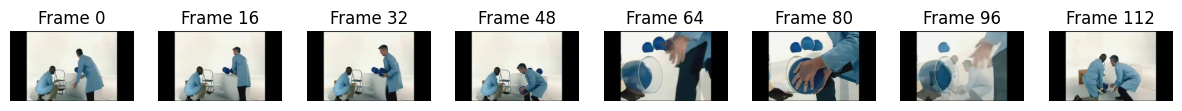

In [5]:
import matplotlib.pyplot as plt
from decord import VideoReader

vr = VideoReader("sample_video.mp4")
frame_idx = np.arange(0, 128, 16)  # Sample every 16th frame
frames = vr.get_batch(frame_idx).asnumpy()

fig, axes = plt.subplots(1, len(frame_idx), figsize=(15, 3))
for i, (ax, frame) in enumerate(zip(axes, frames)):
    ax.imshow(frame)
    ax.set_title(f"Frame {frame_idx[i]}")
    ax.axis("off")
plt.show()